In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchsummary
import matplotlib.pyplot as plt
!pip install kornia
import kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 55.4 MB/s eta 0:00:00


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# get mean

def calc_mean_std():
    overallmean = {}
    overallstd = {}

    finalmeans = []
    finalstds = []

    for X, _ in training_loader:
        for channel in range(X.shape[1]):
            if str(channel) not in list(overallmean.keys()):
                overallmean[str(channel)] = 0
                overallstd[str(channel)] = 0
            overallmean[str(channel)] += X[:, channel, :, :].mean()
            overallstd[str(channel)] += X[:, channel, :, :].std()

    for _, value in overallstd.items():
        value /= len(training_loader)
        finalstds.append(value.item())

    for _, value in overallmean.items():
        value /= len(training_loader)
        finalmeans.append(value.item())

    return (finalmeans, finalstds)

# calc_mean_std()

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(p=0.3), #using kornia
    # transforms.RandomRotation(degrees=15),
    transforms.Normalize(mean=(0.507127583026886, 0.4866163730621338, 0.440956175327301),
                         std=(0.2662975490093231, 0.2555457651615143, 0.2750532031059265))
])

In [ ]:
#Download dataset

training_set = datasets.CIFAR100('./data', train=True, download=True, transform=transform)
testing_set = datasets.CIFAR100('./data', train=False, download=True, transform=transform)

subsets = random_split(testing_set, [5000, 5000])

dev_set = subsets[0]
testing_set = subsets[1]

100%|██████████| 169M/169M [00:03<00:00, 43.5MB/s]


In [ ]:
#Dataloaders

training_loader = DataLoader(training_set, batch_size=256, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev_set, batch_size=20000, shuffle=False, pin_memory=True)
testing_loader = DataLoader(testing_set, batch_size=20000, shuffle=False, pin_memory=True)

In [ ]:
len(training_loader.dataset), len(testing_loader.dataset), len(dev_loader.dataset)

(50000, 5000, 5000)

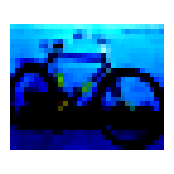

In [ ]:
# visualizing some examples

random_index = np.random.choice(5000)

pixels, label = training_set[random_index]
pixels, label = pixels.cpu().numpy(), label

pixels = np.transpose(pixels, (1, 2, 0))

plt.figure(figsize=(2, 2))
plt.imshow(pixels)
plt.axis('off')
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.augmentations_on_gpu = nn.Sequential(
            kornia.augmentation.RandomHorizontalFlip(p=0.5),
            kornia.augmentation.RandomRotation(degrees=12),
            kornia.augmentation.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            kornia.augmentation.RandomCrop(size=(32,32),padding=4),

        )

        self.feature_extractors = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1),# just get per square pool

            # nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0), # resize back to 256 channels
            # nn.BatchNorm2d(256),
            # nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        ).to(device)

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(self.get_in_features(), 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(256, 100)
        )

    def forward(self, x):
        if self.training:
            x = self.augmentations_on_gpu(x)
        x = self.feature_extractors(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

    def get_in_features(self):
        dummy = torch.randn((1, 3, 32, 32)).to(device)
        temp = self.feature_extractors(dummy)
        shape = self.flatten(temp).shape[1]
        return shape

In [ ]:
model = CNN().to(device)

In [ ]:
def get_accuracy(loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            output = model(X)
            preds = (torch.argmax(output, 1) == y).sum().item()
            correct += preds

    model.train()
    return correct / len(loader.dataset)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0)
loss_fn = nn.CrossEntropyLoss()
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.2)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=20, eta_min=1e-3)

def train(epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X, y in training_loader:
            X, y = X.to(device), y.to(device) #convert to gpu if available

            optimizer.zero_grad()
            output = model(X)

            loss = loss_fn(output, y)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        lr_scheduler.step()
        epoch_loss /= len(training_loader)
        # !nvidia-smi
        print(f'[Epoch: {epoch+1}] | loss: {epoch_loss}   training accuracy: {get_accuracy(training_loader)}   dev accuracy: {get_accuracy(dev_loader)} | lr: {optimizer.param_groups[0]['lr']}')

train(epochs=20)

[Epoch: 1] | loss: 4.236144157088533   training accuracy: 0.11826   dev accuracy: 0.1132 | lr: 0.00994459753267812
[Epoch: 2] | loss: 3.8611503900313866   training accuracy: 0.18492   dev accuracy: 0.1822 | lr: 0.009779754323328192
[Epoch: 3] | loss: 3.6499911887305125   training accuracy: 0.22504   dev accuracy: 0.2184 | lr: 0.009509529358847656
[Epoch: 4] | loss: 3.478471432413374   training accuracy: 0.2711   dev accuracy: 0.2608 | lr: 0.009140576474687263
[Epoch: 5] | loss: 3.3350908038567524   training accuracy: 0.29162   dev accuracy: 0.288 | lr: 0.008681980515339461
[Epoch: 6] | loss: 3.189793254647936   training accuracy: 0.33506   dev accuracy: 0.3288 | lr: 0.008145033635316127
[Epoch: 7] | loss: 3.0789247167353726   training accuracy: 0.37446   dev accuracy: 0.358 | lr: 0.0075429572488279585
[Epoch: 8] | loss: 2.988439849444798   training accuracy: 0.38744   dev accuracy: 0.3688 | lr: 0.006890576474687262


In [ ]:
# torch.cuda.empty_cache()